In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import chardet
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adamax 
from keras import regularizers
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NNDL/Assignment2 /IMDB_Dataset.csv')
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [ ]:
labels = df['label']
def featureEngineering(rev):
    # Lower case rev
    revMod = rev.lower()
    # Replace URLs with a space in the message
    revMod = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', revMod)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    revMod = re.sub('\$[a-zA-Z0-9]*', ' ', revMod)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    revMod = re.sub('\@[a-zA-Z0-9]*', ' ', revMod)
    # Replace everything not a letter or apostrophe with a space
    revMod = re.sub('[^a-zA-Z\']', ' ', revMod)
    # Remove single letter words
    revMod = ' '.join([w for w in revMod.split() if len(w) > 1])

    return revMod


# Process for all revs
df['modrev'] = [featureEngineering(rev) for rev in df['review']]

def lemmatizerev(rev):
    words = [word for word in word_tokenize(rev) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return " ".join(lemmatized)

df['lemmatizedText'] = df["modrev"].apply(lambda x:lemmatizerev(x))

In [ ]:
labels = tf.keras.utils.to_categorical(labels, 3, dtype="float32")
tokenizer = Tokenizer(num_words=37320, split=' ')
tokenizer.fit_on_texts(df['lemmatizedText'].values)
X = tokenizer.texts_to_sequences(df['lemmatizedText'].values)
X = pad_sequences(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.3, random_state=42)


In [ ]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35000, 1407) (35000, 3)
(15000, 1407) (15000, 3)


In [ ]:
model_dropout = Sequential()
model_dropout.add(Embedding(input_dim=37320, output_dim=40, input_length=X.shape[1]))
model_dropout.add(Dropout(0.5))
model_dropout.add(Bidirectional(LSTM(units=256, return_sequences=True, kernel_initializer='he_uniform')))
model_dropout.add(Dropout(0.5))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False, kernel_initializer='he_uniform')))
model_dropout.add(Dense(3, activation='softmax'))
optimizer = Adamax(lr = 0.01)
model_dropout.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
print(model_dropout.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1407, 40)          1492800   
                                                                 
 dropout (Dropout)           (None, 1407, 40)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1407, 512)        608256    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1407, 512)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 7

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [ ]:
history = model_dropout.fit(X_train, Y_train, epochs = 20, batch_size=128, validation_data=(X_test, Y_test))

Epoch 1/20
274/274 [==============================] - 230s 809ms/step - loss: 0.4938 - categorical_accuracy: 0.7394 - val_loss: 0.2926 - val_categorical_accuracy: 0.8815
Epoch 2/20
274/274 [==============================] - 226s 824ms/step - loss: 0.2771 - categorical_accuracy: 0.8908 - val_loss: 0.2954 - val_categorical_accuracy: 0.8741
Epoch 3/20
274/274 [==============================] - 224s 820ms/step - loss: 0.2255 - categorical_accuracy: 0.9147 - val_loss: 0.3318 - val_categorical_accuracy: 0.8885
Epoch 4/20
274/274 [==============================] - 224s 817ms/step - loss: 0.1858 - categorical_accuracy: 0.9301 - val_loss: 0.2947 - val_categorical_accuracy: 0.8906
Epoch 5/20
274/274 [==============================] - 224s 817ms/step - loss: 0.1591 - categorical_accuracy: 0.9430 - val_loss: 0.3309 - val_categorical_accuracy: 0.8857
Epoch 6/20
274/274 [==============================] - 224s 817ms/step - loss: 0.1470 - categorical_accuracy: 0.9476 - val_loss: 0.3047 - val_categoric

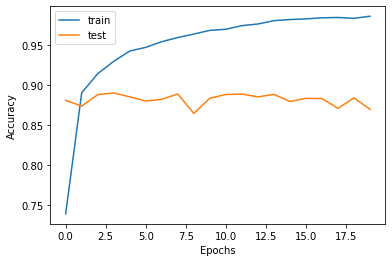

In [ ]:
# Plotting the accuracies
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./overall_acc.png')

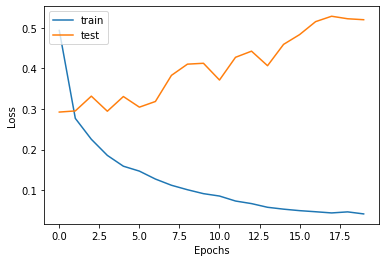

In [ ]:
# Plotting the losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('./overall_loss.png')

In [ ]:
model_dropout.save('./overall')
model_dropout.save('./overall.h5')